In [60]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from semseg import get_mask
from skimage import color

In [51]:
SIZE = 256
# SIZE = 64
def get_prominent_colors(img, n_colors=5, weights=(5, 3, 1), resize=True, blur=True):
    if resize:
        img = cv2.resize(img, (SIZE, SIZE))

    mask = get_mask(img)
    mask = mask.reshape(-1)

    if blur:
        # blur image
        for _ in range(10):
            # img = cv2.GaussianBlur(img, (5, 5), 0)
            img = cv2.GaussianBlur(img, (3, 3), 0)

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    clt = KMeans(n_clusters=n_colors)
    points = img_hsv.reshape(-1, 3)
    
    # apply mask
    points = points[mask.astype(bool)]

    print(f"before: {len(points)}")
    points = points[points[:, 2] > 50]
    print(f"after: {len(points)}")

    points = points * np.array(weights)
    labels = clt.fit_predict(points)
    cluster_weights = np.bincount(labels)
    cluster_weights = cluster_weights / cluster_weights.sum()
    closest_points = []
    centroids = clt.cluster_centers_
    for centroid in centroids:
        closest_points.append(points[np.argmin(np.linalg.norm(points - centroid, axis=1))])
    closest_points = np.array(closest_points) / np.array(weights)
    centroids = centroids / np.array(weights)
    return centroids, cluster_weights, closest_points

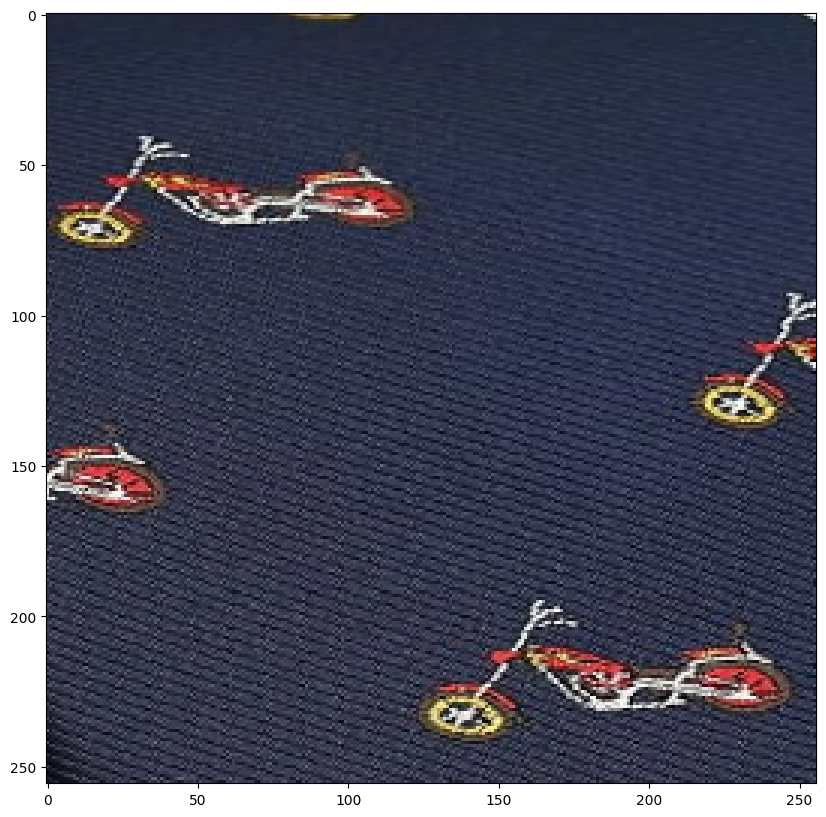

In [54]:
plt.figure(figsize=(10, 10))

# path = 'dataset_v0/81fQJtHh72L._AC_SX679_.jpg'
path = 'dataset_v0/91jUzDDrjwL._AC_SX679_.jpg'
assert(os.path.exists(path))
img = cv2.imread(path)
red_img = img.copy()

red_img = img[55:500, 215:450, :]

# mask = get_mask(red_img)
# red_img[mask == 0] = 0

# for _ in range(10):
#     red_img = cv2.GaussianBlur(red_img, (3, 3), 0)

# plt.imshow(cv2.cvtColor(red_img, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.resize(cv2.cvtColor(red_img, cv2.COLOR_BGR2RGB), (SIZE, SIZE)))

before: 92383
after: 80833


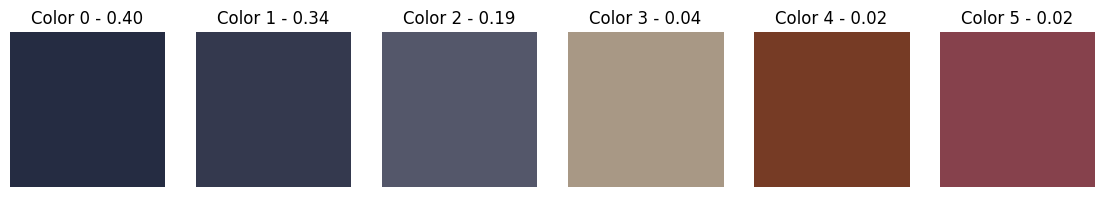

In [58]:
K = 6
N = K
cols = min(8, N)
rows = (N // cols) + 1
fig = plt.figure(figsize=(14, 7)) 
centroids, weights, center_points = get_prominent_colors(red_img, K, weights=(5, 3, 1), resize=False, blur=False)
# centroids, weights, center_points = get_prominent_colors(red_img, K, weights=(1, 1, 1), resize=False)
sorted_inx = np.argsort(weights)[::-1]
centroids = centroids[sorted_inx[:N]]
weights = weights[sorted_inx[:N]]
center_points = center_points[sorted_inx[:N]]
for i in range(len(weights)):
    fig.add_subplot(rows, cols, i+1) 
    plt.title(f'Color {i} - {weights[i]:.2f}')
    hsv = [int(x) for x in centroids[i]]
    # hsv = [int(x) for x in center_points[i]]
    square = np.full((5, 5, 3), hsv, dtype=np.uint8)
    plt.imshow(cv2.cvtColor(square, cv2.COLOR_HSV2RGB))
    plt.axis('off')